## Using LSTMs with the subwords dataset

- compare the results of using a model with an Embedding layer and then adding bidirectional LSTM layers.

- work with the dataset of subwords for the combined Yelp and Amazon reviews.

- use our models to predict the sentiment of new reviews.

In [ ]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Get the dataset

Start by getting the dataset containing Amazon and Yelp reviews, with their related sentiment (1 for positive, 0 for negative). This dataset was originally extracted from [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set).


In [ ]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2020-10-17 15:23:26--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 74.125.20.139, 74.125.20.102, 74.125.20.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.20.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qr1vljhec6352h9eig8aplpddfleglsq/1602948150000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P [following]
--2020-10-17 15:23:26--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qr1vljhec6352h9eig8aplpddfleglsq/1602948150000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)|74.125.195

In [ ]:
import pandas as pd 
dataset = pd.read_csv('/tmp/sentiment.csv')

dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [ ]:
# Extract sentences and labels 
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

In [ ]:
print(len(sentences))
sentences[100]

1992


'Integrated seamlessly with the Motorola RAZR phone.'

In [ ]:
# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




## Create a subwords dataset

We will use the Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality. 

SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

We'll create a subword vocab_size of only the 1,000 most common subwords, as well as cutting off each subword to be at most 5 characters.

Check out the related documentation for the the subword text encoder [here](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder#build_from_corpus).

vocab_size : int, approximate size of the vocabulary to create.
max_subword_length : maximum length of a subword. Note that memory and compute scale quadratically in the length of the longest token.



In [ ]:
import tensorflow_datasets as tfds 
vocab_size = 1000
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences,vocab_size,max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)


Vocab size is  999


In [ ]:
print(tokenizer.subwords[0:100])

['the_', 'and_', 's_', 'I_', 'a_', 'to_', 'is_', 't_', 'was_', 'y_', 'd_', 'e_', 'The_', 'it_', 'of_', 'this_', 'for_', 'not_', 'in_', 'r_', 'my_', 'ed_', 'with_', 'ly_', 'phone', 'ing_', 'on_', 'very_', 're', 'that_', 'have_', 'place', 'ce_', 'it', 'great', 'good_', 'l_', 'n_', 'you_', 'had_', 'are_', 'so_', 'This_', 'h_', 'but_', 'be_', 've_', 'at_', 'servi', 'food_', 'ce', 'ne', 'er', 'It_', 'li', 'ma', 'm_', 'ar', 'nt', 'es', 'as_', 'ta', 'er_', 'de', 'like_', 'all_', 'k_', 'es_', 'se', 'sa', 'le', 'me', 'vi', 'o_', 'to', 'fa', 'ed', 'pa', 'con', 'one_', 'is', 'ri', 'on', 'et', 'ke', 'ct', 'were_', 'ti', 'te', 'ic', 'pe', 'would', 'we', 'me_', 'la', 'ha', 'di', 've', 'un', 'thing']


In [ ]:
## check encoding and decoding for a sample sentence
sample_sentence=tokenizer.encode("good badwords badxyz")
print(sample_sentence)
print("\n")
decode_sample_sentence= tokenizer.decode(sample_sentence)
print(decode_sample_sentence)
print("\n")
for i,j in zip(sample_sentence,decode_sample_sentence):
  print(i,"--",j)

[36, 103, 843, 630, 239, 3, 103, 843, 863, 864, 865]


good badwords badxyz


36 -- g
103 -- o
843 -- o
630 -- d
239 --  
3 -- b
103 -- a
843 -- d
863 -- w
864 -- o
865 -- r


In [ ]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [ ]:
# Separately print out each subword, decoded
for i in encoded:
  print(i,"---->",tokenizer.decode([i]))

4 ----> I 
31 ----> have 
6 ----> to 
849 ----> j
162 ----> ig
450 ----> gl
12 ----> e 
1 ----> the 
600 ----> pl
438 ----> ug
775 ---->  
6 ----> to 
175 ----> get 
14 ----> it 
6 ----> to 
55 ----> li
213 ----> ne 
159 ----> up 
474 ----> right
775 ---->  
6 ----> to 
175 ----> get 
614 ----> dec
380 ----> ent 
295 ----> vo
148 ----> lu
72 ----> me
789 ----> .


## Replace sentence data with encoded subwords
Now, we'll create the sequences to be used for training by actually encoding each of the individual sentences. This is equivalent to text_to_sequences with the Tokenizer we used in earlier exercises.

In [ ]:
for i ,sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

In [ ]:
# Check the sentences are appropriately replaced
print(sentences[50])
print(tokenizer.decode(sentences[50]))

[385, 140, 637, 775, 403, 44, 2, 197, 60, 853, 782, 8, 389, 775, 27, 65, 14, 328, 503, 789]
Not loud enough and doesn't turn on like it should.


## Final pre-processing
Before training, we still need to pad the sequences, as well as split into training and test sets.



In [ ]:
import numpy as np

max_length =50
trunc_type = 'post'
padding_type ='post'

# pad all sequences 
sequences_padded = pad_sequences(sentences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
'''
from sklearn.model_selection import train_test_split
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, labels, test_size=0.20)

#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
training_sequences = X_train
testing_sequences = X_test
training_labels_final = np.array(y_train)
testing_labels_final = np.array(y_test)
'''

## Create the model using an Embedding

Keras offers an Embedding layer that can be used for neural networks on text data.

It requires that the input data be integer encoded, so that each word is represented by a unique integer. This data preparation step can be performed using the Tokenizer API also provided with Keras.

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

It must specify 3 arguments:

- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
                tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                tf.keras.layers.GlobalAveragePooling1D(),
                tf.keras.layers.Dense(6, activation='relu'),
                tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences,training_labels_final,epochs=num_epochs,validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6926 - accuracy: 0.5217 - val_loss: 0.6911 - val_accuracy: 0.6341
Epoch 2/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6271 - val_loss: 0.6864 - val_accuracy: 0.6942
Epoch 3/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6814 - accuracy: 0.7119 - val_loss: 0.6794 - val_accuracy: 0.6792
Epoch 4/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6701 - accuracy: 0.7175 - val_loss: 0.6683 - val_accuracy: 0.6942
Epoch 5/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.7596 - val_loss: 0.6514 - val_accuracy: 0.7393
Epoch 6/30
50/50 [==============================] - 0s 3ms/step - loss: 0.6269 - accuracy: 0.7790 - val_loss: 0.6299 - val_accuracy: 0.7393
Epoch 7/30
50/50 [==============================] - 0s 4ms/step - loss: 0.5950 - accuracy: 0.8117 - val_loss: 0.6052 - val_accuracy: 0.7619
Epoch 8/30
50/50 [==

## Plot the accuracy and loss

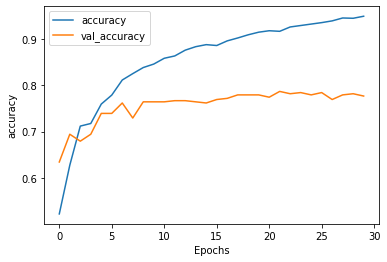

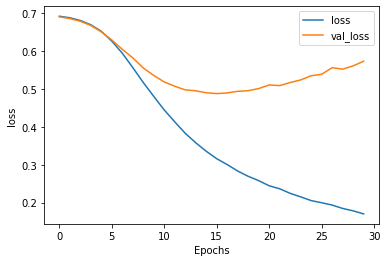

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Define a function to predict the sentiment of reviews
We'll be creating models with some differences and will use each model to predict the sentiment of some new reviews.

To save time, create a function that will take in a model and some new reviews, and print out the sentiment of each reviews.

The higher the sentiment value is to 1, the more positive the review is.

In [ ]:
# Define a function to take a series of reviews
# and predict whether each one is a positive or negative review

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [ ]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.8770169]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.0900024]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.24458337]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.07709263]


[  1 109 228 540 237 635 241

## Define a function to train and show the results of models with different layers
In the rest of this colab, we will define models, and then see the results.

Define a function that will take the model, compile it, train it, graph the accuracy and loss, and then predict some results.



In [ ]:
def fit_model_now(model,sentence):
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results(history):
  plot_graphs(history,"accuracy")
  plot_graphs(history,"loss")

def fit_model_and_show_results(model,sentences):
  history = fit_model_now(model,sentence)
  plot_results(history)
  predict_review(model,sentences)

## Add a bidirectional LSTM
Create a new model that uses a bidirectional LSTM.

Then use the function we have already defined to compile the model, train it, graph the accuracy and loss, then predict some results.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 1s 21ms/step - loss: 0.6919 - accuracy: 0.5330 - val_loss: 0.6891 - val_accuracy: 0.6667
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.6630 - accuracy: 0.6830 - val_los

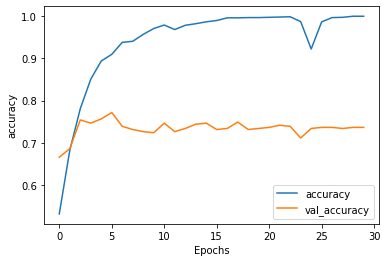

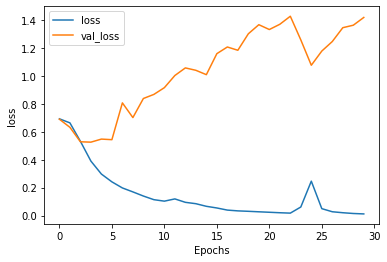

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99762315]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.01881821]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.9990464]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.17172225]


[  1 109 228 540 237 635 24

In [ ]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
                    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                    tf.keras.layers.Dense(6, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)


## Use multiple bidirectional layers
Now let's see if we get any improvements from adding another Bidirectional LSTM layer to the model.

Notice that the first Bidirectionl LSTM layer returns a sequence.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            16000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 26,701
Trainable params: 26,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 2s 38ms/step - loss: 0.6931 - accuracy: 0.5129 - val_loss: 0.694

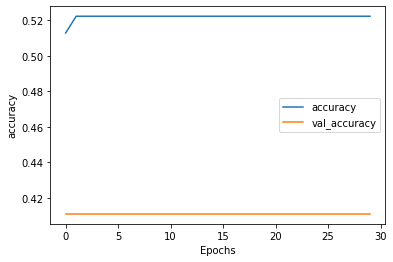

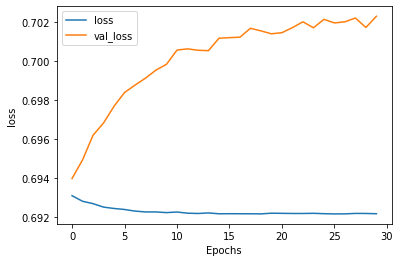

[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.52273256]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.52273256]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.52273256]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was green
[0.52273256]


[  1 109 228 540 237 635 2

In [ ]:
model_multiple_bidi_lstm = tf.keras.Sequential([
                                    tf.keras.layers.Embedding(vocab_size, embedding_dim,input_length=max_length),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim,return_sequences='True')),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                                    tf.keras.layers.Dense(6, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

# Compare predictions for all the models

It can be hard to see which model gives a better prediction for different reviews when you examine each model separately. So for comparison purposes, here we define some more reviews and print out the predictions that each of the three models gives for each review:

*   Embeddings and a Global Average Pooling layer
*   Embeddings and a Bidirectional LSTM layer
*   Embeddings and two Bidirectional LSTM layers

The results are not always what you might expect. The input dataset is fairly small, it has less than 2000 reviews. Some of the reviews are fairly short, and some of the short ones are fairly repetitive which reduces their impact on improving the  model, such as these two reviews:

*   Bad Quality.
*   Low Quality.

Feel free to add more reviews of your own, or change the reviews. The results will depend on the combination of words in the reviews, and how well they match to reviews in the training set. 

How do the different models handle things like "wasn't good" which contains a positive word (good) but is a poor review?


In [ ]:
my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             "you cannot always be right for a wrong person and right one will find your worth"
             ]

In [ ]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
lovely
[0.8904595]


dreadful
[0.27054015]


stay away
[0.5754046]


everything was hot exactly as I wanted
[0.6821106]


everything was not exactly as I wanted
[0.40439418]


they gave us free chocolate cake
[0.67449737]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.02761161]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.43959102]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.8124607]


that place does not have quality meals and it isn't a good place to go for dinner
[0.81647277]


you cannot always be right for a wrong person and right one will find your worth
[0.6390922]




In [ ]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
lovely
[0.9571382]


dreadful
[0.0557842]


stay away
[0.03836138]


everything was hot exactly as I wanted
[0.99925727]


everything was not exactly as I wanted
[0.55732054]


they gave us free chocolate cake
[0.99757594]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.68161154]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.01458064]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.9999465]


that place does not have quality meals and it isn't a good place to go for dinner
[0.9977749]


you cannot always be right for a wrong person and right one will find your worth
[0.99894005]




In [ ]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
lovely
[0.52273256]


dreadful
[0.52273256]


stay away
[0.52273256]


everything was hot exactly as I wanted
[0.52273256]


everything was not exactly as I wanted
[0.52273256]


they gave us free chocolate cake
[0.52273256]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.52273256]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.52273256]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.52273256]


that place does not have quality meals and it isn't a good place to go for dinner
[0.52273256]


you cannot always be right for a wrong person and right one will find your worth
[0.52273256]


